# Data Preparation 2

This code aims to merge rainfall data from Nimrod System (https://catalogue.ceda.ac.uk/uuid/27dd6ffba67f667a18c62de5c3456350/) to the hourly bike count data

## There are some steps to follow first to unpack the raw data:
1. Download the raw data in spesific date ('bike_count/processed/unique_dates') placed them in directory 'MetOffice_NIMROD/tar'

2. Extract them manually and placed them to 'MetOffice_NIMROD/gz'

3. Filter the files only for 06:00 to 22:00 and placed them into 'MetOffice_NIMROD/filtered_gz'. The code is below (see the comment)

In [3]:
# This code is for filter the files for 06:00 to 22:00
# This code won't be executed
'''

import os
import shutil
import re
from datetime import datetime

# Define the source directory
# Change the year of the directory
source_dir = 'MetOffice_NIMROD/gz/2024' #change the year from 2014 - 2024

# Define the target directory for filtered files 
# Change the year of the directory
filtered_dir = 'MetOffice_NIMROD/filtered_gz/2024' #change the year from 2014 - 2024

# Define the time range for filtering
start_time = datetime.strptime("06:00", "%H:%M").time()
end_time = datetime.strptime("22:00", "%H:%M").time()

# Regex pattern to extract 12-digit datetime string
datetime_pattern = re.compile(r"(\d{12})")

# Debug: List to log filtered files
filtered_files_log = []

# Iterate through files in the source directory
for file_name in os.listdir(source_dir):
    # Check if the file has the expected .gz extension
    if file_name.endswith(".dat.gz"):
        try:
            # Search for the datetime string in the filename
            match = datetime_pattern.search(file_name)
            if match:
                date_time_str = match.group(1)  # Extract the 12-digit datetime string
                file_time = datetime.strptime(date_time_str, "%Y%m%d%H%M")

                # Debug: Print parsed time
                print(f"Processing file: {file_name}, Extracted Time: {file_time.strftime('%H:%M')}")

                # Check if the time falls within the desired range
                if start_time <= file_time.time() < end_time:  # Modified comparison
                    # Copy the file to the filtered directory
                    src_path = os.path.join(source_dir, file_name)
                    dest_path = os.path.join(filtered_dir, file_name)
                    shutil.copy(src_path, dest_path)
                    filtered_files_log.append(file_name)
                else:
                    print(f"Skipping file (out of range): {file_name}")

        except Exception as e:
            print(f"Error processing file {file_name}: {e}")

# Debug: Print filtered files summary
print("Filtered Files:")
for f in filtered_files_log:
    print(f)

print("Filtering complete. Filtered files are saved in:", filtered_dir)

'''

<>:2: SyntaxWarning: invalid escape sequence '\d'
<>:2: SyntaxWarning: invalid escape sequence '\d'
C:\Users\arthu\AppData\Local\Temp\ipykernel_4044\3043455940.py:2: SyntaxWarning: invalid escape sequence '\d'
  '''


'\n\nimport os\nimport shutil\nimport re\nfrom datetime import datetime\n\n# Define the source directory\n# Change the year of the directory\nsource_dir = r"2.gz(all_hours_per_15_mins)/2024"\n\n# Define the target directory for filtered files \n# Change the year of the directory\nfiltered_dir = r"3.filtered_files_gz_06.00-22.00/2024"\n\n# Define the time range for filtering\nstart_time = datetime.strptime("06:00", "%H:%M").time()\nend_time = datetime.strptime("22:00", "%H:%M").time()\n\n# Regex pattern to extract 12-digit datetime string\ndatetime_pattern = re.compile(r"(\\d{12})")\n\n# Debug: List to log filtered files\nfiltered_files_log = []\n\n# Iterate through files in the source directory\nfor file_name in os.listdir(source_dir):\n    # Check if the file has the expected .gz extension\n    if file_name.endswith(".dat.gz"):\n        try:\n            # Search for the datetime string in the filename\n            match = datetime_pattern.search(file_name)\n            if match:\n   

## Try to open 1 Nimrod File

To open the Nimrod File, there is a python code from https://dap.ceda.ac.uk/badc/ukmo-nimrod/software/python/nimrod.py?download=1

But, I have modified the code to only convert the data into array only, so the processed will be more efficient

The modified code stored in 'MetOffice_NIMROD/nimrod_modified.py'

Due to unlimited storage, I did not unpacked the .gz file to be .dat file, what I have done here is to store the unpacked .gz file into the memory and straightly processed them into numpy array.

In [1]:
from MetOffice_NIMROD.nimrod_modified import Nimrod
import os
import numpy as np
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt
import gzip

In [3]:
# Open the gzipped NIMROD file
with gzip.open('MetOffice_NIMROD/filtered_gz/2024/metoffice-c-band-rain-radar_uk_202407091300_1km-composite.dat.gz', 'rb') as gz_file:
    # Pass the decompressed stream to Nimrod
    rainfall_data = Nimrod(gz_file)

# Get the raster data as a NumPy array (no bounding box)
rainfall_array = rainfall_data.get_array(xmin=500000, xmax=560000, ymin=155000, ymax=200000)

# Inspect the array
print("Array shape:", rainfall_array.shape)
print("Sample data:\n", rainfall_array)

# Check the minimum and maximum values
min_value = rainfall_array.min()
max_value = rainfall_array.max()

print("Minimum value in the array:", min_value)
print("Maximum value in the array:", max_value)

Array shape: (46, 61)
Sample data:
 [[30 39 47 ...  0  0  0]
 [36 33 51 ...  0  0  0]
 [43 39 62 ...  0  0  0]
 ...
 [ 6  8  5 ...  5  7  5]
 [ 6  8  6 ...  8  5  0]
 [10 10  5 ...  7  5  0]]
Minimum value in the array: 0
Maximum value in the array: 652


## Open All Nimrod Files

At this point, I try to open all the .gz files and turned them into numpy array. 

First, define the process for the iteration.

In [4]:
# Definition to open .gz files

def process_file(file_path, xmin, xmax, ymin, ymax):
    """Process a single .gz file and return the rainfall array."""
    try:
        with gzip.open(file_path, 'rb') as gz_file:
            # Attempt to load the file using Nimrod
            rainfall_data = Nimrod(gz_file)
            # Extract the rainfall array for the specified bounding box
            rainfall_array = rainfall_data.get_array(xmin=xmin, xmax=xmax, ymin=ymin, ymax=ymax)
            return rainfall_array
    except Exception as e:
        # Print an error message for debugging
        print(f"Error processing file {file_path}: {e}")
        # Return None or an empty array to indicate the failure gracefully
        return None

In [5]:
# Helper function to parse filenames and group files

def parse_filename(filename):
    # Assumes filename structure: ..._YYYYMMDDHHMM_...
    date_hour_minute = filename.split('_')[2]  # Extract YYYYMMDDHHMM
    date = date_hour_minute[:8]  # Extract YYYYMMDD
    hour = date_hour_minute[8:10]  # Extract HH
    minute = date_hour_minute[10:12]  # Extract MM
    return date, hour, minute


# Group files by date and hour

def group_files(directory_path):
    files_by_date_hour = defaultdict(lambda: defaultdict(list))
    for file_name in os.listdir(directory_path):
        if file_name.endswith('.gz'):
            date, hour, minute = parse_filename(file_name)
            files_by_date_hour[date][hour].append(os.path.join(directory_path, file_name))
    return files_by_date_hour

definition of the value in NIMROD files from the website https://catalogue.ceda.ac.uk/uuid/27dd6ffba67f667a18c62de5c3456350/


![](<attachment:Screenshot 2025-01-09 204834.png>)
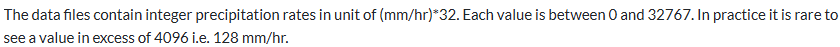

In [6]:
# Processes grouped files

def process_hourly_files(files_by_date_hour, xmin, xmax, ymin, ymax):
    """Process hourly files grouped by date and hour."""
    hourly_data_by_date = {}
    for date, hours in sorted(files_by_date_hour.items()):
        print(f"Processing date: {date}")
        hourly_data = []  # Store hourly rasters for the date
        
        for hour, file_paths in sorted(hours.items()):
            hourly_data_list = []
            
            # Process all 5-minute interval files for this hour
            for file_path in sorted(file_paths):
                rainfall_array = process_file(file_path, xmin, xmax, ymin, ymax)
                if rainfall_array is not None:  # Check if processing was successful
                    rainfall_array_mm_hr = rainfall_array / 32.0  # Convert to mm/hr
                    hourly_data_list.append(rainfall_array_mm_hr)
                else:
                    print(f"Skipping file {file_path} due to processing error.")
            
            # Aggregate the hour (sum all 5-minute intervals)
            if hourly_data_list:  # Ensure there is data to aggregate
                hourly_sum = np.sum(hourly_data_list, axis=0) / 12.0  # Average over the hour
                hourly_data.append(hourly_sum)  # Append hourly sum
                print(f"Processed hour {hour}: Shape {hourly_sum.shape}, Max Rainfall: {hourly_sum.max()} mm/hr, Min Rainfall: {hourly_sum.min()} mm/hr")
        
        # Stack hourly data for the date into a 3D array
        if hourly_data:  # Ensure there is data for the date
            hourly_data_by_date[date] = np.stack(hourly_data)  # Shape: (16, rows, cols)
            print(f"Finished processing date: {date}, daily stack shape: {hourly_data_by_date[date].shape}")
    
    return hourly_data_by_date

In [7]:
def aggregate_to_final_raster_stack(hourly_data_by_date):
    """
    Aggregate hourly raster data into a 4D stack.
    
    Parameters:
        hourly_data_by_date (dict): Dictionary where keys are dates and values are 3D numpy arrays 
                                    (shape: hours, rows, cols).
    
    Returns:
        numpy.ndarray: Aggregated raster stack across all dates (shape: dates, hours, rows, cols).
    """
    # List to store the 3D arrays for each date
    all_data = []

    for date, data in sorted(hourly_data_by_date.items()):  # Sort by date for consistent order
        all_data.append(data)  # Append 3D hourly data for the date

    # Combine into a single 4D numpy array
    final_raster_stack = np.stack(all_data, axis=0)  # Stack along the date axis (axis=0)
    
    return final_raster_stack

## Iteration for Every Year (2014 - 2024)

Due to limited memory, I split the process per year. 

Let's try from

### Year 2024

In [8]:
# Define the directory and bounding box
directory_path = 'MetOffice_NIMROD/filtered_gz/2024' #change the year
xmin, xmax, ymin, ymax = 500000, 560000, 155000, 200000

# Group files by date and hour
files_by_date_hour_2024 = group_files(directory_path) #change the year

# Process hourly files
hourly_data_by_date_2024 = process_hourly_files(files_by_date_hour_2024, xmin, xmax, ymin, ymax) #change the year

# Inspect results
for date, data in hourly_data_by_date_2024.items(): #change the year
    print(f"Date: {date}, Data shape: {data.shape}")

Processing date: 20240411
Processed hour 06: Shape (46, 61), Max Rainfall: 0.010416666666666666 mm/hr, Min Rainfall: 0.0 mm/hr
Processed hour 07: Shape (46, 61), Max Rainfall: 0.0026041666666666665 mm/hr, Min Rainfall: 0.0 mm/hr
Processed hour 08: Shape (46, 61), Max Rainfall: 0.06770833333333333 mm/hr, Min Rainfall: 0.0 mm/hr
Processed hour 09: Shape (46, 61), Max Rainfall: 0.0 mm/hr, Min Rainfall: 0.0 mm/hr
Processed hour 10: Shape (46, 61), Max Rainfall: 0.0234375 mm/hr, Min Rainfall: 0.0 mm/hr
Processed hour 11: Shape (46, 61), Max Rainfall: 0.005208333333333333 mm/hr, Min Rainfall: 0.0 mm/hr
Processed hour 12: Shape (46, 61), Max Rainfall: 0.0 mm/hr, Min Rainfall: 0.0 mm/hr
Processed hour 13: Shape (46, 61), Max Rainfall: 2.4635416666666665 mm/hr, Min Rainfall: 0.0 mm/hr
Processed hour 14: Shape (46, 61), Max Rainfall: 0.0 mm/hr, Min Rainfall: 0.0 mm/hr
Processed hour 15: Shape (46, 61), Max Rainfall: 0.0 mm/hr, Min Rainfall: 0.0 mm/hr
Processed hour 16: Shape (46, 61), Max Rainfa

In [9]:
# Filter out dates with inconsistent data shapes
consistent_hourly_data_by_date = {
    date: data
    for date, data in hourly_data_by_date_2024.items()
    if data.shape == (16, 46, 61)  # Keep only consistent shapes
}

# Inspect the remaining dates
print(f"Remaining dates: {len(consistent_hourly_data_by_date)} out of {len(hourly_data_by_date_2024)}")
print(f"Dropped dates: {[date for date in hourly_data_by_date_2024 if date not in consistent_hourly_data_by_date]}")

# Aggregate the consistent data into the final raster stack
final_raster_stack_2024 = aggregate_to_final_raster_stack(consistent_hourly_data_by_date)

# Inspect the shape of the final raster stack
print(f"Final raster stack shape 2024: {final_raster_stack_2024.shape}")

Remaining dates: 54 out of 54
Dropped dates: []
Final raster stack shape 2024: (54, 16, 46, 61)


In [10]:
# Raster stack details
rows = final_raster_stack_2024.shape[2]
cols = final_raster_stack_2024.shape[3]
xres = (xmax - xmin) / cols
yres = (ymax - ymin) / rows

# Dates and hours inferred from the consistent dataset
dates = sorted(consistent_hourly_data_by_date.keys())  # Use filtered data
hours = list(range(6, 22))  # Hours from 6:00 to 21:00

# Print details
print("Available Dates:")
for date in dates:
    print(date)
print("\nAvailable Hours:")
print(hours)
print("\nRaster Spatial Dimensions:")
print(f"Rows: {rows}, Cols: {cols}")
print(f"Resolution: xres = {xres}, yres = {yres}")

Available Dates:
20240411
20240416
20240417
20240418
20240421
20240422
20240423
20240424
20240425
20240426
20240429
20240430
20240501
20240502
20240503
20240507
20240508
20240509
20240510
20240513
20240514
20240515
20240516
20240517
20240520
20240521
20240522
20240523
20240524
20240528
20240529
20240603
20240604
20240605
20240606
20240611
20240612
20240613
20240618
20240619
20240620
20240625
20240626
20240627
20240702
20240703
20240704
20240709
20240710
20240711
20240716
20240717
20240718
20240723

Available Hours:
[6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]

Raster Spatial Dimensions:
Rows: 46, Cols: 61
Resolution: xres = 983.6065573770492, yres = 978.2608695652174


### Merge with Counting Bike Points (2024)

In [11]:
# Load the bike count CSV file
data_2024 = pd.read_csv('bike_count/processed/yearly_data/bike_count_2024.csv')

# Convert the 'Date' column to datetime, allowing flexibility for mixed formats
data_2024['Date'] = pd.to_datetime(data_2024['Date'])

#only apply the date_list from raster stack
data_2024 = data_2024[data_2024['Date'].isin(dates)]

# Inspect the result
print(data_2024['Date'].unique())

<DatetimeArray>
['2024-07-16 00:00:00', '2024-07-23 00:00:00', '2024-05-15 00:00:00',
 '2024-07-09 00:00:00', '2024-04-30 00:00:00', '2024-05-01 00:00:00',
 '2024-05-08 00:00:00', '2024-05-09 00:00:00', '2024-06-26 00:00:00',
 '2024-05-23 00:00:00', '2024-06-04 00:00:00', '2024-06-13 00:00:00',
 '2024-06-05 00:00:00', '2024-06-20 00:00:00', '2024-04-25 00:00:00',
 '2024-07-02 00:00:00', '2024-06-25 00:00:00', '2024-04-17 00:00:00',
 '2024-04-23 00:00:00', '2024-06-27 00:00:00', '2024-06-18 00:00:00',
 '2024-05-22 00:00:00', '2024-06-19 00:00:00', '2024-06-06 00:00:00',
 '2024-05-16 00:00:00', '2024-07-11 00:00:00', '2024-04-24 00:00:00',
 '2024-07-03 00:00:00', '2024-04-18 00:00:00', '2024-05-21 00:00:00',
 '2024-06-11 00:00:00', '2024-06-12 00:00:00', '2024-05-07 00:00:00',
 '2024-05-14 00:00:00', '2024-05-02 00:00:00', '2024-04-26 00:00:00',
 '2024-04-29 00:00:00', '2024-07-04 00:00:00', '2024-04-16 00:00:00',
 '2024-05-10 00:00:00', '2024-05-13 00:00:00', '2024-05-17 00:00:00',
 '20

C:\Users\arthu\AppData\Local\Temp\ipykernel_9756\3120289308.py:8: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  data_2024 = data_2024[data_2024['Date'].isin(dates)]


In [12]:
# Reformat the Date column in the table to match raster date format
data_2024['Date'] = pd.to_datetime(data_2024['Date']).dt.strftime('%Y%m%d')

print(data_2024['Date'].unique())

['20240716' '20240723' '20240515' '20240709' '20240430' '20240501'
 '20240508' '20240509' '20240626' '20240523' '20240604' '20240613'
 '20240605' '20240620' '20240425' '20240702' '20240625' '20240417'
 '20240423' '20240627' '20240618' '20240522' '20240619' '20240606'
 '20240516' '20240711' '20240424' '20240703' '20240418' '20240521'
 '20240611' '20240612' '20240507' '20240514' '20240502' '20240426'
 '20240429' '20240704' '20240416' '20240510' '20240513' '20240517'
 '20240520' '20240503' '20240422' '20240603' '20240524' '20240528'
 '20240529' '20240717' '20240718' '20240710' '20240411' '20240421']


In [13]:
# Function to compute indices
def get_indices(row):
    # Temporal indices
    date_index = dates.index(row['Date'])  # Get date index from the list
    hour_index = hours.index(int(row['Hour']))  # Get hour index (6–21)
    
    # Spatial indices
    x_index = int((row['Easting'] - xmin) / xres)
    y_index = int((row['Northing'] - ymin) / yres)

    return date_index, hour_index, y_index, x_index

# Function to extract rainfall
def get_rainfall(row):
    date_index, hour_index, y_index, x_index = get_indices(row)

    # Check bounds
    if (0 <= date_index < final_raster_stack_2024.shape[0] and #change the year
        0 <= hour_index < final_raster_stack_2024.shape[1] and #change the year
        0 <= y_index < rows and
        0 <= x_index < cols):
        return final_raster_stack_2024[date_index, hour_index, y_index, x_index] #change the year
    else:
        return np.nan  # Return NaN if out of bounds

# Apply rainfall extraction
data_2024['rainfall'] = data_2024.apply(get_rainfall, axis=1) #change the year

# Save updated table
data_2024.to_csv('MetOffice_NIMROD/output/2024/bikecount_with_rainfall_2024.csv', index=False) #change the year

### Validate the overlay process 
In this step, I only want to validate whether the overlay works fine

Taking example on date 20240709 hour 13, for UnqID ML1111, here is the screenshot of the csv file (MetOffice_NIMROD/output/2024/bikecount_with_rainfall_2024.csv)

![Screenshot 2025-01-09 192811.png](<attachment:Screenshot 2025-01-09 192811.png>)
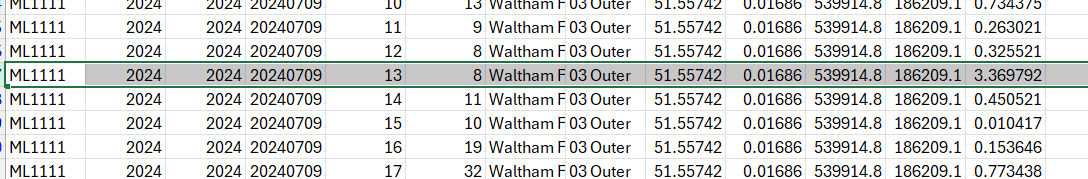

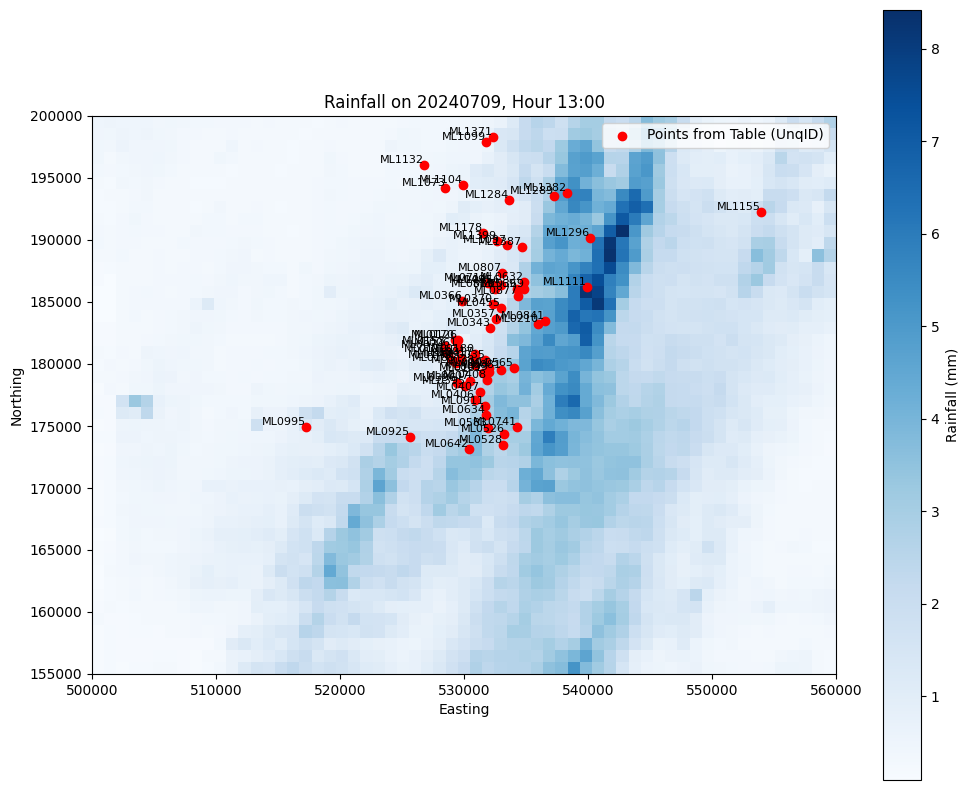

In [14]:
import matplotlib.pyplot as plt

# Specify the target date and hour
target_date = "20240709"
target_hour = 13

# Step 1: Filter the points for the specific date and hour
filtered_points = data_2024[(data_2024['Date'] == target_date) & (data_2024['Hour'] == target_hour)]

# Step 2: Find the indices for the date and hour
date_index = dates.index(target_date)  
hour_index = hours.index(target_hour) 

# Step 3: Extract the raster slice for the specified date and hour
raster_slice = final_raster_stack_2024[date_index, hour_index]  # Change the year

# Step 4: Visualize the raster with points overlaid
plt.figure(figsize=(12, 10))
plt.imshow(
    raster_slice, 
    cmap='Blues', 
    origin='upper', 
    extent=[xmin, xmax, ymin, ymax]  # Align raster to spatial coordinates
)
plt.colorbar(label='Rainfall (mm)')
plt.title(f"Rainfall on {target_date}, Hour {target_hour}:00")
plt.xlabel("Easting")
plt.ylabel("Northing")

# Overlay the points with UnqID annotations
for _, row in filtered_points.iterrows():
    plt.scatter(
        row['Easting'], 
        row['Northing'], 
        color='red', 
        label=row['UnqID'] if row.name == filtered_points.index[0] else ""  # Prevent duplicate legends
    )
    # Annotate the points with UnqID
    plt.text(
        row['Easting'], 
        row['Northing'], 
        row['UnqID'], 
        fontsize=8, 
        color='black', 
        ha='right', 
        va='bottom'
    )

# Add a legend for the points
plt.legend(['Points from Table (UnqID)'])
plt.grid(False)
plt.show()

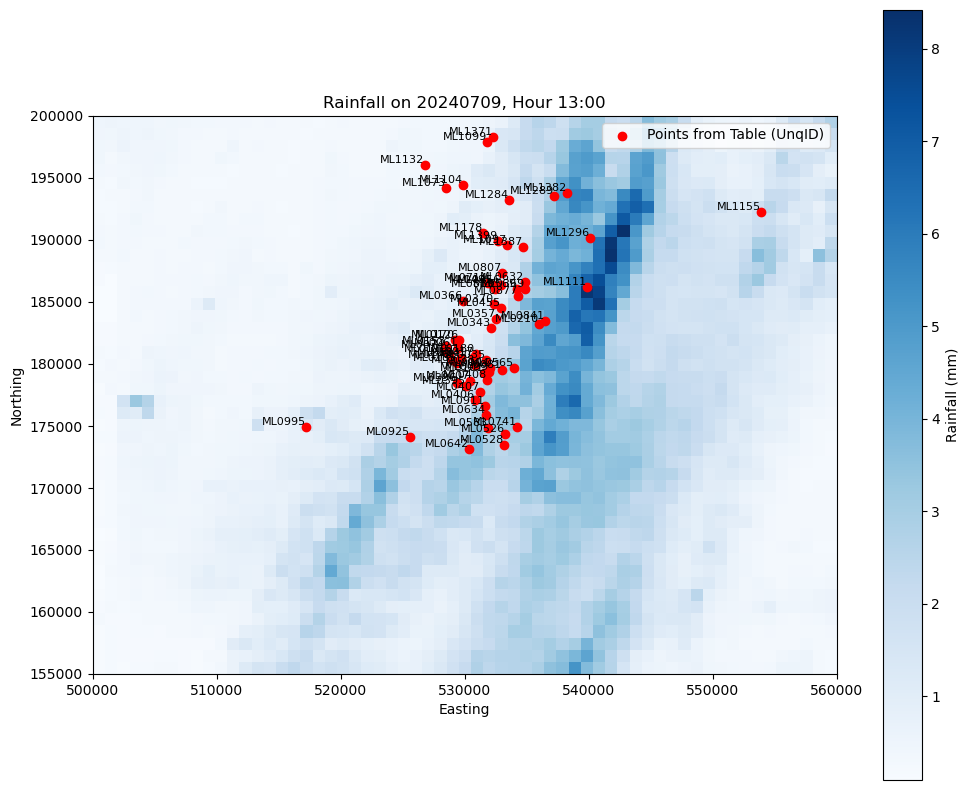

However, if you spot the ML1111 in the map, the colour is not indicating that the value is 3,36. It must be more than that.

Here I try to validate by the ML1111's cell value and filter only to ML1111.

In [16]:
ml1111_raster_value = final_raster_stack_2024[date_index, hour_index, 31, 40]
print(f"Raster value at ML1111's cell: {ml1111_raster_value}")

Raster value at ML1111's cell: 3.3697916666666665


In [17]:
def get_indices(row):
    # Temporal indices
    date_index = dates.index(row['Date'])  # Match the date
    hour_index = hours.index(int(row['Hour']))  # Match the hour
    
    # Spatial indices
    x_index = int((row['Easting'] - xmin) / xres)
    y_index = int((row['Northing'] - ymin) / yres)
    
    return date_index, hour_index, y_index, x_index

def get_rainfall(row):
    date_index, hour_index, y_index, x_index = get_indices(row)
    
    # Check bounds
    if (0 <= date_index < final_raster_stack.shape[0] and
        0 <= hour_index < final_raster_stack.shape[1] and
        0 <= y_index < rows and
        0 <= x_index < cols):
        return final_raster_stack[date_index, hour_index, y_index, x_index]
    else:
        return np.nan  # Out of bounds

# Define the bounding box and resolution of the raster
xmin, xmax = 500000, 560000  # Example values for Easting
ymin, ymax = 155000, 200000  # Example values for Northing
cols = 61  # Number of raster columns
rows = 46  # Number of raster rows
xres = (xmax - xmin) / cols  # Spatial resolution in x-direction
yres = (ymax - ymin) / rows  # Spatial resolution in y-direction

# Coordinates for ML1111
easting_ml1111 = 539914.82
northing_ml1111 = 186209.1075

# Compute spatial indices
x_index = int((easting_ml1111 - xmin) / xres)
y_index = int((northing_ml1111 - ymin) / yres)

# Print results
print(f"Spatial indices for ML1111:")
print(f"x_index (column): {x_index}")
print(f"y_index (row): {y_index}")

Spatial indices for ML1111:
x_index (column): 40
y_index (row): 31


In [18]:
# Filter data from bikecount_with_rainfall_2024.csv for ML1111, specific date, and hour
filtered_data = data_2024[
    (data_2024['UnqID'] == 'ML1111') & 
    (data_2024['Date'] == '20240709') & 
    (data_2024['Hour'] == 13)
]

# Extract rainfall value from CSV
if not filtered_data.empty:
    csv_rainfall = filtered_data['rainfall'].values[0]  # Get the rainfall value
else:
    print("No matching record found in the CSV for ML1111, 20240709, Hour 13.")
    csv_rainfall = None

# Temporal indices for the raster
date_index = dates.index("20240709")  # Index for the date
hour_index = hours.index(13)         # Index for the hour

# Extract rainfall value from the raster at the computed indices
raster_rainfall = final_raster_stack_2024[date_index, hour_index, 31, 40]  # Use y_index and x_index

# Print comparison
print(f"Rainfall value from raster at (date_index={date_index}, hour_index={hour_index}, y_index=31, x_index=40): {raster_rainfall}")
if csv_rainfall is not None:
    print(f"Rainfall value from CSV for ML1111: {csv_rainfall}")

    # Check for mismatch
    if raster_rainfall != csv_rainfall:
        print("Discrepancy found between raster and CSV values.")
    else:
        print("Rainfall values match between raster and CSV.")

Rainfall value from raster at (date_index=47, hour_index=7, y_index=31, x_index=40): 3.3697916666666665
Rainfall value from CSV for ML1111: 3.3697916666666665
Rainfall values match between raster and CSV.


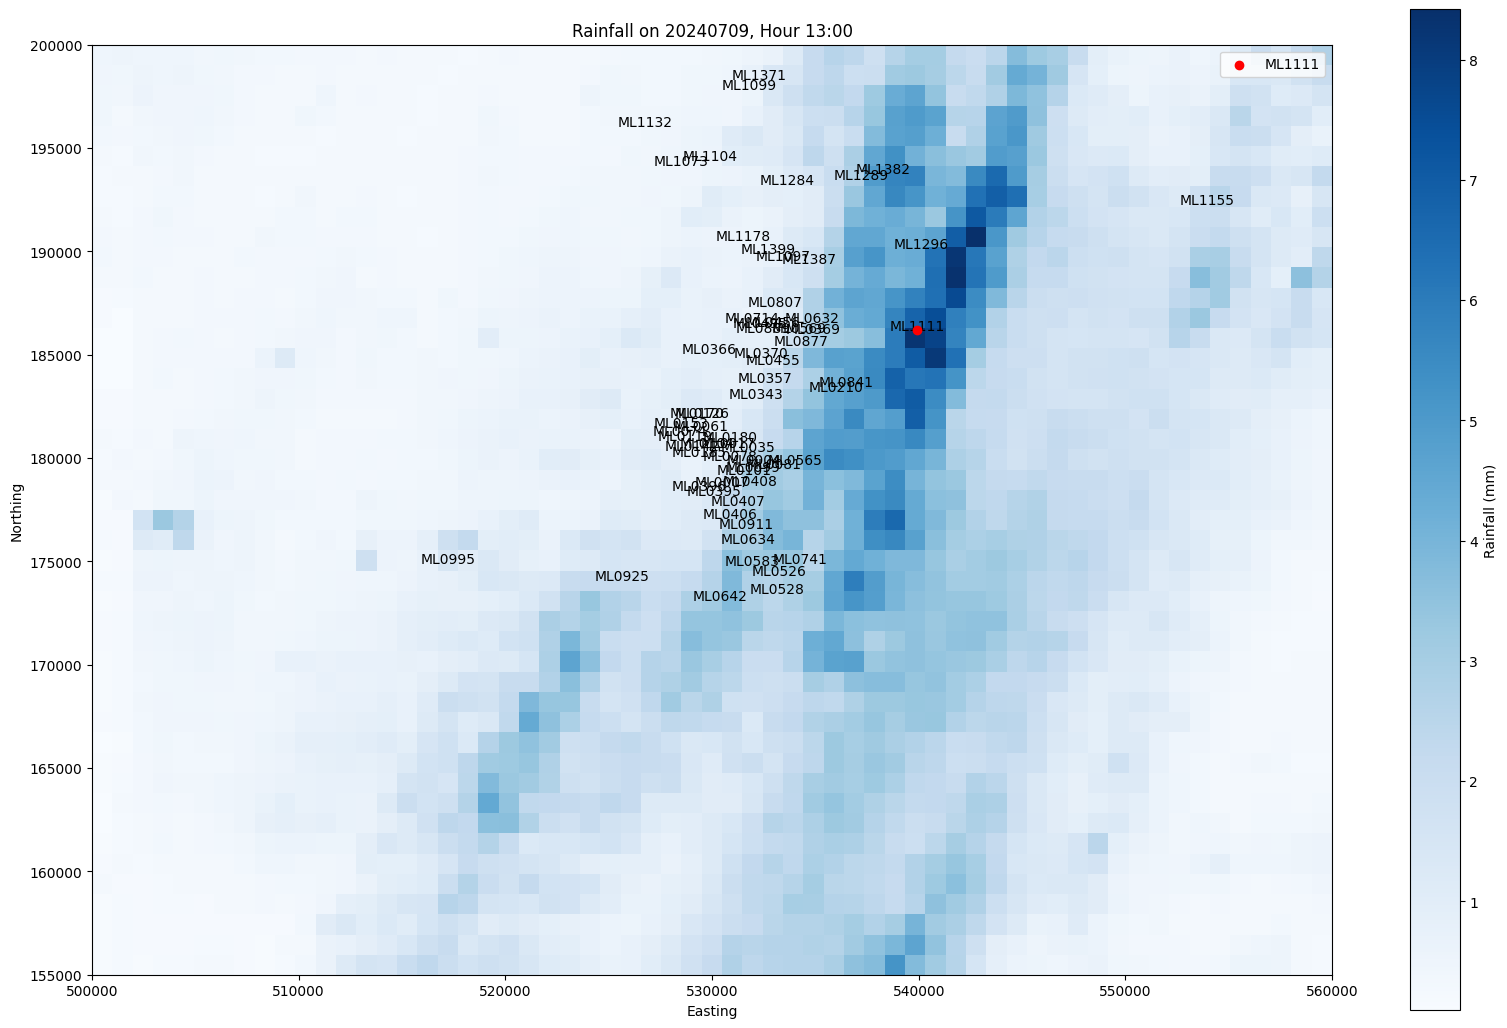

In [21]:
# Specify the target date and hour
target_date = "20240709"
target_hour = 13

# Step 1: Filter the points for the specific date and hour
filtered_points = data_2024[(data_2024['Date'] == target_date) & (data_2024['Hour'] == target_hour)]

# Step 2: Find the indices for the date and hour
date_index = dates.index(target_date)  # Index for 20240716
hour_index = hours.index(target_hour)  # Index for hour 17

# Step 3: Extract the raster slice for the specified date and hour
raster_slice = final_raster_stack_2024[date_index, hour_index] #change the year

# Step 4: Visualize the raster with points overlaid
plt.figure(figsize=(20, 13))
plt.imshow(
    raster_slice, 
    cmap='Blues', 
    origin='upper', 
    extent=[xmin, xmax, ymin, ymax],  # Align raster to spatial coordinates
    interpolation='none'  # Disable interpolation
)
plt.colorbar(label='Rainfall (mm)')
plt.title(f"Rainfall on {target_date}, Hour {target_hour}:00")
plt.xlabel("Easting")
plt.ylabel("Northing")

# Add `UNqID` labels for each point
for _, row in filtered_points.iterrows():
    plt.text(
        row['Easting'], 
        row['Northing'], 
        str(row['UnqID']),  # Replace with the column containing unique IDs
        fontsize=10, 
        color='black',
        ha='center'
    )

plt.scatter(
    [539914.82], [186209.1075],  # Easting and Northing for ML1111
    color='red', label='ML1111', zorder=5
)
plt.legend()
plt.show()


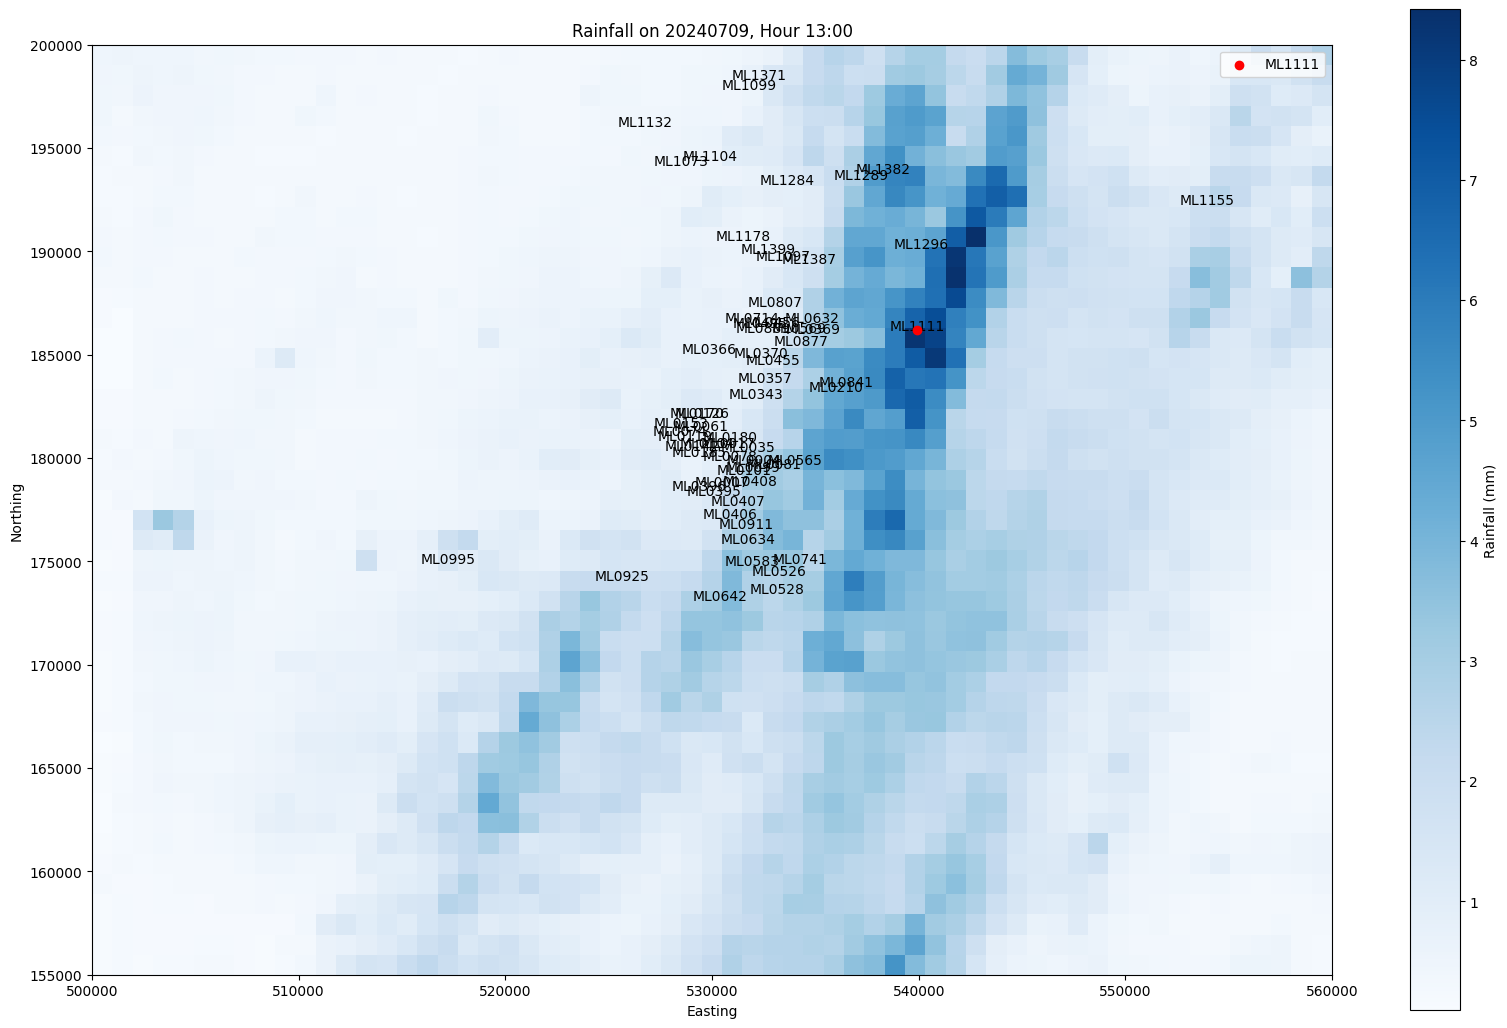

In Conclusion, the csv file (output of the code) showed the value is 3.69 but the visualization is more than that. 